In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

Загрузка датасета

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


Запуск модели

In [3]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    losses = []
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses_epoch = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            losses_epoch.append(loss*actual_batch_size)
            
            '''
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            '''          
                
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses_epoch)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
    if plot_losses:
        plt.plot(losses)
        plt.grid(True)
        plt.title('Epoch {} Loss'.format(e+1))
        plt.xlabel('minibatch number')
        plt.ylabel('minibatch loss')
        plt.show()
    return total_loss,total_correct

Модель

In [21]:
# Первоначальная модель
# Feel free to play with this cell
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def my_model(X,y,is_training):
    # define our weights
    W1 = tf.get_variable('W1', shape=[7, 7, 3, 32])
    b1 = tf.get_variable('b1', shape=[32])
    W2 = tf.get_variable('W2', shape=[5408, 1024])
    b2 = tf.get_variable('b2', shape=[1024])
    W3 = tf.get_variable('W3', shape=[1024, 10])
    b3 = tf.get_variable('b3', shape=[10])
    
    conv  = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='VALID') + b1
    relu1 = tf.nn.relu(conv)
    bn = tf.layers.batch_normalization(relu1, training=is_training)
    pool  = tf.nn.max_pool(bn, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    pool_flat = tf.reshape(pool, [-1,5408])
    af1 = tf.matmul(pool_flat, W2) + b2
    relu2 = tf.nn.relu(af1)
    af2 = tf.matmul(relu2, W3) + b3
    y_out = af2
    
    return y_out


y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out))
lr = 1e-2
#optimizer = tf.train.RMSPropOptimizer(lr) # select optimizer and set learning rate
optimizer = tf.train.AdamOptimizer(lr)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [6]:
# 2 conv layers
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

F1 = 32
H_f1 = 7
H_c1 = (32 - H_f1 + 1)/1       #26
H_pool1 = ((H_c1 - 2)/2) + 1   #13
w2_size0 = int(F1*H_pool1*H_pool1)   #5408

F2 = 32
H_f2 = 6
pad2 = 1
H_c2 = (H_pool1 - H_f2 + 1)/1  #8
H_pool2 = ((H_c2 - 2)/2) + 1     #4
w3_size0 = int(F2*H_pool2*H_pool2)     #512

def my_model(X,y,is_training):
    # define our weights
    W1 = tf.get_variable('W1', shape=[H_f1, H_f1, 3, F1])
    b1 = tf.get_variable('b1', shape=[F1])
    
    W2 = tf.get_variable('W2', shape=[H_f2, H_f2, 32, F2])
    b2 = tf.get_variable('b2', shape=[F2])
    
    W3 = tf.get_variable('W3', shape=[w3_size0, 1024])
    b3 = tf.get_variable('b3', shape=[1024])
    W4 = tf.get_variable('W4', shape=[1024, 10])
    b4 = tf.get_variable('b4', shape=[10])
    
    conv1  = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='VALID') + b1
    relu1 = tf.nn.relu(conv1)
    pool1  = tf.nn.max_pool(relu1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    #bn = tf.layers.batch_normalization(relu1, training=is_training)
    #pool  = tf.nn.max_pool(bn, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv2  = tf.nn.conv2d(pool1, W2, strides=[1,1,1,1], padding='VALID') + b2
    relu2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(relu2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    pool_flat = tf.reshape(pool2, [-1,w3_size0])
    af1 = tf.matmul(pool_flat, W3) + b3
    relu3 = tf.nn.relu(af1)
    af2 = tf.matmul(relu3, W4) + b4
    y_out = af2
    
    return y_out


y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out))
lr = 1e-2
#optimizer = tf.train.RMSPropOptimizer(lr) # select optimizer and set learning rate
optimizer = tf.train.AdamOptimizer(lr)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [26]:
# 2 conv layers + bn
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

F1 = 32
H_f1 = 7
H_c1 = (32 - H_f1 + 1)/1       #26
H_pool1 = ((H_c1 - 2)/2) + 1   #13
w2_size0 = int(F1*H_pool1*H_pool1)   #5408

F2 = 32
H_f2 = 6
pad2 = 1
H_c2 = (H_pool1 - H_f2 + 1)/1  #8
H_pool2 = ((H_c2 - 2)/2) + 1     #4
w3_size0 = int(F2*H_pool2*H_pool2)     #512

def my_model(X,y,is_training):
    # define our weights
    W1 = tf.get_variable('W1', shape=[H_f1, H_f1, 3, F1])
    b1 = tf.get_variable('b1', shape=[F1])
    
    W2 = tf.get_variable('W2', shape=[H_f2, H_f2, 32, F2])
    b2 = tf.get_variable('b2', shape=[F2])
    
    W3 = tf.get_variable('W3', shape=[w3_size0, 1024])
    b3 = tf.get_variable('b3', shape=[1024])
    W4 = tf.get_variable('W4', shape=[1024, 10])
    b4 = tf.get_variable('b4', shape=[10])
    
    conv1  = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='VALID') + b1
    relu1 = tf.nn.relu(conv1)
    pool1  = tf.nn.max_pool(relu1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    bn1 = tf.layers.batch_normalization(pool1, training=is_training)
    #pool  = tf.nn.max_pool(bn, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv2  = tf.nn.conv2d(bn1, W2, strides=[1,1,1,1], padding='VALID') + b2
    relu2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(relu2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    bn2 = tf.layers.batch_normalization(pool2, training=is_training)
    
    pool_flat = tf.reshape(bn2, [-1,w3_size0])
    af1 = tf.matmul(pool_flat, W3) + b3
    relu3 = tf.nn.relu(af1)
    af2 = tf.matmul(relu3, W4) + b4
    y_out = af2
    
    return y_out


y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out))
lr = 5e-4
#optimizer = tf.train.RMSPropOptimizer(lr) # select optimizer and set learning rate
optimizer = tf.train.AdamOptimizer(lr)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [8]:
# 2 conv layers + bn + 2fc
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

F1 = 32
H_f1 = 7
H_c1 = (32 - H_f1 + 1)/1       #26
H_pool1 = ((H_c1 - 2)/2) + 1   #13
w2_size0 = int(F1*H_pool1*H_pool1)   #5408

F2 = 32
H_f2 = 6
pad2 = 1
H_c2 = (H_pool1 - H_f2 + 1)/1  #8
H_pool2 = ((H_c2 - 2)/2) + 1     #4
w3_size0 = int(F2*H_pool2*H_pool2)     #512

def my_model(X,y,is_training):
    # define our weights
    W1 = tf.get_variable('W1', shape=[H_f1, H_f1, 3, F1])
    b1 = tf.get_variable('b1', shape=[F1])
    
    W2 = tf.get_variable('W2', shape=[H_f2, H_f2, 32, F2])
    b2 = tf.get_variable('b2', shape=[F2])
    
    W3 = tf.get_variable('W3', shape=[w3_size0, 1024])
    b3 = tf.get_variable('b3', shape=[1024])
    
    W4 = tf.get_variable('W4', shape=[1024, 1024])
    b4 = tf.get_variable('b4', shape=[1024])
    W5 = tf.get_variable('W5', shape=[1024, 1024])
    b5 = tf.get_variable('b5', shape=[1024])
    W6 = tf.get_variable('W6', shape=[1024, 10])
    b6 = tf.get_variable('b6', shape=[10])
    
    conv1  = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='VALID') + b1
    relu1 = tf.nn.relu(conv1)
    pool1  = tf.nn.max_pool(relu1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    bn1 = tf.layers.batch_normalization(pool1, training=is_training)
    #pool  = tf.nn.max_pool(bn, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv2  = tf.nn.conv2d(bn1, W2, strides=[1,1,1,1], padding='VALID') + b2
    relu2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(relu2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    bn2 = tf.layers.batch_normalization(pool2, training=is_training)
    
    pool_flat = tf.reshape(bn2, [-1,w3_size0])
    af1 = tf.matmul(pool_flat, W3) + b3
    relu3 = tf.nn.relu(af1)
    af2 = tf.matmul(relu3, W4) + b4
    
    relu4 = tf.nn.relu(af2)
    af3 = tf.matmul(relu4, W5) + b5
    relu5 = tf.nn.relu(af3)
    af4 = tf.matmul(relu5, W6) + b6
    
    
    
    y_out = af4
    
    return y_out


y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out))
lr = 5e-4
#optimizer = tf.train.RMSPropOptimizer(lr) # select optimizer and set learning rate
optimizer = tf.train.AdamOptimizer(lr)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [17]:
# 2 conv layers + bn + 1024->2048
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

F1 = 32
H_f1 = 7
H_c1 = (32 - H_f1 + 1)/1       #26
H_pool1 = ((H_c1 - 2)/2) + 1   #13
w2_size0 = int(F1*H_pool1*H_pool1)   #5408

F2 = 32
H_f2 = 6
pad2 = 1
H_c2 = (H_pool1 - H_f2 + 1)/1  #8
H_pool2 = ((H_c2 - 2)/2) + 1     #4
w3_size0 = int(F2*H_pool2*H_pool2)     #512

def my_model(X,y,is_training):
    # define our weights
    W1 = tf.get_variable('W1', shape=[H_f1, H_f1, 3, F1])
    b1 = tf.get_variable('b1', shape=[F1])
    
    W2 = tf.get_variable('W2', shape=[H_f2, H_f2, 32, F2])
    b2 = tf.get_variable('b2', shape=[F2])
    
    W3 = tf.get_variable('W3', shape=[w3_size0, 2048])
    b3 = tf.get_variable('b3', shape=[2048])
    W4 = tf.get_variable('W4', shape=[2048, 10])
    b4 = tf.get_variable('b4', shape=[10])
    
    conv1  = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='VALID') + b1
    relu1 = tf.nn.relu(conv1)
    pool1  = tf.nn.max_pool(relu1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    bn1 = tf.layers.batch_normalization(pool1, training=is_training)
    #pool  = tf.nn.max_pool(bn, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv2  = tf.nn.conv2d(bn1, W2, strides=[1,1,1,1], padding='VALID') + b2
    relu2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(relu2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    bn2 = tf.layers.batch_normalization(pool2, training=is_training)
    
    pool_flat = tf.reshape(bn2, [-1,w3_size0])
    af1 = tf.matmul(pool_flat, W3) + b3
    relu3 = tf.nn.relu(af1)
    af2 = tf.matmul(relu3, W4) + b4
    y_out = af2
    
    return y_out


y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out))
lr = 5e-4
#optimizer = tf.train.RMSPropOptimizer(lr) # select optimizer and set learning rate
optimizer = tf.train.AdamOptimizer(lr)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [4]:
# 2 conv layers + bn + 1024->2048 + change H_f
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

F1 = 32
H_f1 = 3
H_c1 = (32 - H_f1 + 1)/1       #26
H_pool1 = ((H_c1 - 2)/2) + 1   #13
w2_size0 = int(F1*H_pool1*H_pool1)   #5408

F2 = 32
H_f2 = 2
pad2 = 1
H_c2 = (H_pool1 - H_f2 + 1)/1  #8
H_pool2 = ((H_c2 - 2)/2) + 1     #4
w3_size0 = int(F2*H_pool2*H_pool2)     #512

def my_model(X,y,is_training):
    # define our weights
    W1 = tf.get_variable('W1', shape=[H_f1, H_f1, 3, F1])
    b1 = tf.get_variable('b1', shape=[F1])
    
    W2 = tf.get_variable('W2', shape=[H_f2, H_f2, 32, F2])
    b2 = tf.get_variable('b2', shape=[F2])
    
    W3 = tf.get_variable('W3', shape=[w3_size0, 2048])
    b3 = tf.get_variable('b3', shape=[2048])
    W4 = tf.get_variable('W4', shape=[2048, 10])
    b4 = tf.get_variable('b4', shape=[10])
    
    conv1  = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='VALID') + b1
    relu1 = tf.nn.relu(conv1)
    pool1  = tf.nn.max_pool(relu1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    bn1 = tf.layers.batch_normalization(pool1, training=is_training)
    #pool  = tf.nn.max_pool(bn, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv2  = tf.nn.conv2d(bn1, W2, strides=[1,1,1,1], padding='VALID') + b2
    relu2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(relu2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    bn2 = tf.layers.batch_normalization(pool2, training=is_training)
    
    pool_flat = tf.reshape(bn2, [-1,w3_size0])
    af1 = tf.matmul(pool_flat, W3) + b3
    relu3 = tf.nn.relu(af1)
    af2 = tf.matmul(relu3, W4) + b4
    y_out = af2
    
    return y_out


y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out))
lr = 5e-4
#optimizer = tf.train.RMSPropOptimizer(lr) # select optimizer and set learning rate
optimizer = tf.train.AdamOptimizer(lr)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Обучение модели

Training
Epoch 1, Overall loss = 1.24 and accuracy of 0.585
Epoch 2, Overall loss = 0.658 and accuracy of 0.776
Epoch 3, Overall loss = 0.379 and accuracy of 0.881
Epoch 4, Overall loss = 0.214 and accuracy of 0.934
Epoch 5, Overall loss = 0.181 and accuracy of 0.94
Epoch 6, Overall loss = 0.135 and accuracy of 0.955
Epoch 7, Overall loss = 0.0869 and accuracy of 0.972
Epoch 8, Overall loss = 0.0667 and accuracy of 0.978
Epoch 9, Overall loss = 0.064 and accuracy of 0.979
Epoch 10, Overall loss = 0.0607 and accuracy of 0.98


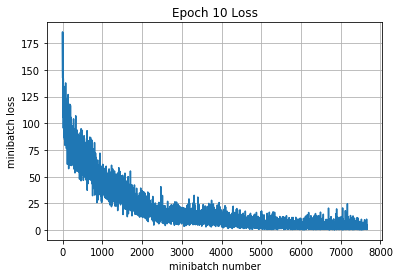

Training
Epoch 1, Overall loss = 0.098 and accuracy of 0.968
Validation
Epoch 1, Overall loss = 1.67 and accuracy of 0.701
Wall time: 47.9 s


In [6]:
%%time
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy

sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Точность на трейне и валидации

In [7]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.098 and accuracy of 0.968
Validation
Epoch 1, Overall loss = 1.67 and accuracy of 0.701


(1.674767809867859, 0.701)

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [7]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.72 and accuracy of 0.704


(1.7242294297218324, 0.704)